In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping

from lightgbm import LGBMRegressor
import random
import xgboost as xgb

In [2]:
curr_dir = os.getcwd()
curr_dir

'C:\\weather\\uv'

In [3]:
forders_tr = os.listdir(curr_dir+"\\data\\"+"\\outlier_train_val")
forders_tr

['2001_uv_nooutlier.csv',
 '2002_uv_nooutlier.csv',
 '2003_uv_nooutlier.csv',
 '2004_uv_nooutlier.csv',
 '2005_uv_nooutlier.csv',
 '2006_uv_nooutlier.csv',
 '2007_uv_nooutlier.csv',
 '2008_uv_nooutlier.csv',
 '2009_uv_nooutlier.csv',
 '2010_uv_nooutlier.csv',
 '2011_uv_nooutlier.csv',
 '2012_uv_nooutlier.csv',
 '2101_uv_nooutlier.csv',
 '2102_uv_nooutlier.csv',
 '2103_uv_nooutlier.csv',
 '2104_uv_nooutlier.csv',
 '2105_uv_nooutlier.csv',
 '2106_uv_nooutlier.csv',
 '2107_uv_nooutlier.csv',
 '2108_uv_nooutlier.csv',
 '2109_uv_nooutlier.csv',
 '2110_uv_nooutlier.csv',
 '2111_uv_nooutlier.csv',
 '2112_uv_nooutlier.csv']

In [4]:
summer_tr = forders_tr[4:10] + forders_tr[12+4:12+10-3]
summer_tr

summer_val = forders_tr[12+10-3:12+10]
summer_val

['2108_uv_nooutlier.csv', '2109_uv_nooutlier.csv', '2110_uv_nooutlier.csv']

In [5]:
train = pd.DataFrame()

for files in summer_tr:
    df= pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\outlier_train_val\\")+files)
    train = pd.concat([train, df])
    
train.drop('idx', axis=1, inplace=True)
train

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20200501,0,13,126.16000,33.30000,0.0,0.00000,-0.00057,-0.00030,0.00165,...,252.91737,277.63245,277.03649,275.67037,262.71147,130.35092,38.96359,-6.11462,71.00,0
1,20200501,0,105,128.89098,37.75147,0.0,-0.00057,-0.00057,-0.00060,-0.00090,...,256.69212,286.82011,287.23821,285.51819,269.40510,126.43187,43.95463,-5.60867,26.04,3
2,20200501,0,108,126.96500,37.57100,0.0,0.00000,0.00000,0.00000,0.00090,...,253.85590,281.28558,281.42512,280.03692,266.81080,126.31564,43.77999,-5.59822,85.50,3
3,20200501,0,112,126.62490,37.47772,0.0,0.00000,0.00000,0.00089,0.00030,...,254.78101,283.03827,283.39275,282.06360,268.05385,126.36437,43.67046,-5.60546,68.99,3
4,20200501,0,115,130.89864,37.48129,0.0,0.00000,0.00000,0.00030,0.00075,...,251.68704,277.82840,278.25056,275.71853,262.56565,126.91833,43.74521,-5.66707,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65607,20210731,2350,146,127.11900,35.84080,0.1,0.00000,-0.00057,0.00030,-0.00060,...,264.53165,291.90287,290.09587,285.48855,270.82702,124.36364,41.81018,-4.72602,62.90,3
65608,20210731,2350,152,129.33472,35.58250,0.0,0.00000,0.00000,0.00000,-0.00030,...,262.88449,288.27382,286.67481,282.45891,269.23268,125.09137,41.52495,-4.87156,82.00,2
65609,20210731,2350,156,126.89158,35.17294,0.0,-0.00057,0.00000,0.00000,0.00015,...,262.57588,287.50208,284.96722,280.05240,267.56515,124.95628,41.04849,-4.79509,72.38,3
65610,20210731,2350,159,129.03203,35.10468,0.0,0.00000,0.00000,-0.00119,0.00000,...,262.22936,287.43410,286.66069,283.63739,270.60537,125.49764,40.96396,-4.91507,69.56,3


In [6]:
ratio=[]
num = []
for i in range(len(train.columns)):
    ratio.append(len(train[train[train.columns[i]] == -999.0])/len(train))
    num.append(len(train[train[train.columns[i]] == -999.0]))
ratio

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [7]:
val = pd.DataFrame()

for files in summer_val:
    df= pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\outlier_train_val\\")+files)
    val = pd.concat([val, df])
    
val.drop('idx', axis=1, inplace=True)
val

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20210801,0,13,126.16000,33.30000,0.0,0.00000,-0.00057,0.00089,-0.00015,...,264.44311,290.55389,288.92546,284.67080,270.70772,127.16116,38.96359,-5.60122,71.00,0
1,20210801,0,105,128.89098,37.75147,0.0,-0.00057,-0.00057,0.00000,-0.00015,...,259.14507,283.10942,282.76528,280.43877,268.61000,123.36327,43.95463,-5.09260,26.04,3
2,20210801,0,108,126.96500,37.57100,0.0,0.00000,0.00057,-0.00119,0.00120,...,252.93837,273.65182,270.18990,267.15459,258.99048,123.18739,43.77999,-5.07447,85.50,3
3,20210801,0,112,126.62490,37.47772,0.0,0.00000,0.00000,-0.00030,-0.00060,...,250.27920,268.14394,268.04466,266.56403,259.34748,123.22507,43.67046,-5.08058,68.99,3
4,20210801,0,115,130.89864,37.48129,0.0,0.00000,0.00000,0.00000,-0.00015,...,263.38986,289.67998,288.05013,284.04277,269.26719,123.91259,43.74521,-5.16058,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62893,20211031,2350,146,127.11900,35.84080,0.1,0.00000,-0.00057,0.00030,-0.00015,...,243.98668,261.95199,261.21896,259.29863,250.50021,157.14313,41.81018,-8.56636,62.90,3
62894,20211031,2350,152,129.33472,35.58250,0.0,0.00000,0.00000,-0.00089,0.00120,...,255.89419,281.48837,281.57322,280.00595,265.73255,157.99342,41.52495,-8.67521,82.00,2
62895,20211031,2350,156,126.89158,35.17294,0.0,0.00057,0.00000,0.00000,0.00015,...,246.57815,265.43902,264.76641,262.60697,252.65714,157.69250,41.04849,-8.59148,72.38,3
62896,20211031,2350,159,129.03203,35.10468,0.0,0.00057,0.00000,-0.00179,-0.00060,...,257.75436,284.11394,283.85736,280.96228,265.34129,158.37811,40.96396,-8.68840,69.56,3


In [8]:
ratio=[]
num = []
for i in range(len(val.columns)):
    ratio.append(len(val[val[val.columns[i]] == -999.0])/len(val))
    num.append(len(val[val[val.columns[i]] == -999.0]))
ratio

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [89]:
forders_te = os.listdir(curr_dir+"\\data\\"+"\\test")
forders_te

['202206_uv.csv', '202206_uv_final.csv', '202206_uv_noOutlier.csv']

In [92]:
# forders_te = os.listdir(curr_dir+"\\data\\"+"\\test")
# forders_te

df = pd.read_csv(os.path.join(curr_dir+"\\data\\"+"\\test\\")+forders_te[2])
# d = list(df.columns)
# for j in range(1,len(d)):
#     d[j] = d[j].replace("202206_uv.", "")
# df.columns = d
# df.drop('Unnamed: 0', axis=1, inplace=True)
test = df
test.describe()
test

,yyyymmdd,hhnn,stn,lon,lat,uv,band1,band2,band3,band4,...,band12,band13,band14,band15,band16,SolarZA,sateza,ESR,height,landtype
0,20220601,0,13,126.16000,33.30000,0,0.00000,0.00000,-0.00060,0.00060,...,241.07130,251.49092,250.11913,248.78686,243.12601,123.72706,38.96359,-5.16304,71.00,0
1,20220601,0,105,128.89098,37.75147,0,-0.00057,-0.00057,0.00000,-0.00030,...,244.35010,262.71227,261.14580,257.52658,246.95577,119.74915,43.95463,-4.61100,26.04,3
2,20220601,0,108,126.96500,37.57100,0,0.00000,-0.00057,-0.00030,0.00045,...,249.24111,271.81756,270.25616,266.99858,254.94651,119.65871,43.77999,-4.60329,85.50,3
3,20220601,0,112,126.62490,37.47772,0,0.00000,0.00000,0.00060,0.00045,...,249.94977,273.52547,272.33661,269.12853,256.15036,119.71313,43.67046,-4.61180,68.99,3
4,20220601,0,115,130.89864,37.48129,0,0.00000,0.00000,0.00089,-0.00030,...,239.88321,253.29031,251.46606,249.01625,240.92761,120.21661,43.74521,-4.67107,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51850,20220625,0,146,127.11900,35.84080,0,0.00000,-0.00057,-0.00089,0.00015,...,258.49191,286.87485,287.19605,285.48855,271.35400,119.84431,41.81018,-4.59718,62.90,3
51851,20220625,0,152,129.33472,35.58250,0,-0.00057,0.00000,-0.00030,-0.00030,...,263.99872,293.32422,293.51096,291.15861,274.60342,120.42121,41.52495,-4.67124,82.00,2
51852,20220625,0,156,126.89158,35.17294,0,0.00000,0.00000,0.00089,-0.00030,...,261.53112,290.14436,290.23278,288.05655,273.15633,120.46896,41.04849,-4.68457,72.38,3
51853,20220625,0,159,129.03203,35.10468,0,0.00000,0.00057,0.00030,-0.00075,...,260.95627,287.80066,287.63090,285.01340,270.36623,120.85844,40.96396,-4.73249,69.56,3


In [11]:
ratio=[]
num = []
for i in range(len(test.columns)):
    ratio.append(len(test[test[test.columns[i]] == -999.0])/len(test))
    num.append(len(test[test[test.columns[i]] == -999.0]))
ratio

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.007231703789412786,
 0.007231703789412786,
 0.007231703789412786,
 0.007231703789412786,
 0.007231703789412786,
 0.007231703789412786,
 0.007231703789412786,
 0.007231703789412786,
 0.007231703789412786,
 0.007231703789412786,
 0.007231703789412786,
 0.007231703789412786,
 0.007231703789412786,
 0.007231703789412786,
 0.007231703789412786,
 0.007231703789412786,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

# Model

In [8]:
# max_depth = 5
# n_estimators = 5000             # 400  #1000
# lr = 0.01                     # 0.017
# num_leaves = 31
# early_stopping_rounds = 300      # 100
# verbose = True                  # True

In [14]:
# def model_train(curr_dir):
 
#     path_train = os.path.join(curr_dir+"\\data_rota\\"+"\\train")
#     path_test = os.path.join(curr_dir+"\\data_rota\\"+"\\test")
    
#     folders_tr = os.listdir(path_train)
#     folders_test = os.listdir(path_test)
    
#     train = pd.DataFrame()
#     for files in folders_tr:
#         df= pd.read_csv(os.path.join(curr_dir+"\\data_rota\\"+"\\train\\")+files)
#         train = pd.concat([train, df])            
              
    
#     test = pd.DataFrame()
#     for files in folders_test:
#         df= pd.read_csv(os.path.join(curr_dir+"\\data_rota\\"+"\\test\\")+files)
#         test = pd.concat([test, df])   


#     X_train = train[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
#     X_val = val[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]    
#     X_test = test[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
 
X_train = train.drop('uv',axis=1)
X_val = val.drop('uv',axis=1)
X_test = test.drop('UV',axis=1)
    
y_train = train[['uv']].values
y_val = val[['uv']].values



#     trainx = train[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
#     test1 = test[['band1','band2', 'band3', 'band4','band6', 'band7','band11', 'band12', \
#                      'band13', 'band14', 'band15', 'band16','solarza','esr']]
    
#     trainy = train[['uv']].values

#     X_train, X_val, y_train, y_val = train_test_split(trainx, trainy, test_size=0.3, shuffle=False)
    
#     param_grid = {
#     'n_estimators': [100, 150, 200, 250],
#     'max_depth': [None, 6, 9, 12],
#     'min_samples_split': [0.01, 0.05, 0.1],
#     'max_features': ['auto', 'sqrt']}
    
    
#     kf = KFold(random_state=30,
#            n_splits=3,
#            shuffle=True,
#           )
    
#     model_name = '\\save\\'+'best_model_v1.h5' 

#     filepath = os.path.join(os.getcwd()+ model_name)

#     es = EarlyStopping(monitor='val_mse', verbose=1, patience=20)

#     checkpoint = ModelCheckpoint(filepath=filepath,
#                              monitor='val_mse',
#                              verbose=1,
#                              save_best_only=True)

#     callbacks = [checkpoint, es]



xgb_model = xgb.XGBRegressor(n_estimators = 2000, learning_rate = 0.01, max_depth=11, subsample=0.5,colsample_bytree=0.7, random_state = 2000)

xgb_model.fit(X_train,y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=15)



# lgbm_reg = LGBMRegressor(objective= "regression",
#                      max_depth= max_depth,
#                      n_estimators= n_estimators,
#                      learning_rate= lr,
#                      num_leaves = num_leaves)
    
# lgbm_reg.fit(X_train, y_train,
#           eval_set=[(X_val, y_val)],
#           eval_metric=["mse"],
#           early_stopping_rounds=early_stopping_rounds,
#           verbose=verbose) 



#     estimator = xgb.XGBRegressor()
    # define grid_search
#     grid_search = GridSearchCV(estimator=estimator, 
#                                param_grid=param_grid, 
#                                cv=kf, 
#                                n_jobs=-1, 
#                                verbose=2
#                               )

    # fit with (x_train, y_train)
#     grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=1)
    
#     feature_importance = xgb_model.feature_importances_
#     sorted_idx = np.argsort(feature_importance)
#     fig = plt.figure(figsize=(12, 6))
#     plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
#     plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
#     plt.title('Feature Importance')
    
#     pred = xgb_model.predict(test1)
#     submission=pd.read_csv('1-1_검증데이터셋.csv', encoding='utf-8')
#     submission1=submission.copy()
#     submission1['UV'] = pred
    
#     submission1.to_csv("220224_xgb_uv.csv", index = False)

C:\Users\younjeongOh\anaconda3\envs\tensorflow_env\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:2.14746
[1]	validation_0-rmse:2.12924
[2]	validation_0-rmse:2.11049
[3]	validation_0-rmse:2.09274
[4]	validation_0-rmse:2.07481
[5]	validation_0-rmse:2.05666
[6]	validation_0-rmse:2.03835
[7]	validation_0-rmse:2.01387
[8]	validation_0-rmse:1.99691
[9]	validation_0-rmse:1.97817
[10]	validation_0-rmse:1.95950
[11]	validation_0-rmse:1.94218
[12]	validation_0-rmse:1.92520
[13]	validation_0-rmse:1.90706
[14]	validation_0-rmse:1.88922
[15]	validation_0-rmse:1.87110
[16]	validation_0-rmse:1.85477
[17]	validation_0-rmse:1.83771
[18]	validation_0-rmse:1.82065
[19]	validation_0-rmse:1.80342
[20]	validation_0-rmse:1.78757
[21]	validation_0-rmse:1.77111
[22]	validation_0-rmse:1.75567
[23]	validation_0-rmse:1.74037
[24]	validation_0-rmse:1.72628
[25]	validation_0-rmse:1.71140
[26]	validation_0-rmse:1.69742
[27]	validation_0-rmse:1.68253
[28]	validation_0-rmse:1.66799
[29]	validation_0-rmse:1.65442
[30]	validation_0-rmse:1.64037
[31]	validation_0-rmse:1.62645
[32]	validation_0-

[259]	validation_0-rmse:0.50904
[260]	validation_0-rmse:0.50846
[261]	validation_0-rmse:0.50801
[262]	validation_0-rmse:0.50741
[263]	validation_0-rmse:0.50687
[264]	validation_0-rmse:0.50658
[265]	validation_0-rmse:0.50609
[266]	validation_0-rmse:0.50557
[267]	validation_0-rmse:0.50511
[268]	validation_0-rmse:0.50466
[269]	validation_0-rmse:0.50432
[270]	validation_0-rmse:0.50374
[271]	validation_0-rmse:0.50384
[272]	validation_0-rmse:0.50350
[273]	validation_0-rmse:0.50297
[274]	validation_0-rmse:0.50276
[275]	validation_0-rmse:0.50287
[276]	validation_0-rmse:0.50248
[277]	validation_0-rmse:0.50218
[278]	validation_0-rmse:0.50193
[279]	validation_0-rmse:0.50187
[280]	validation_0-rmse:0.50158
[281]	validation_0-rmse:0.50138
[282]	validation_0-rmse:0.50109
[283]	validation_0-rmse:0.50089
[284]	validation_0-rmse:0.50056
[285]	validation_0-rmse:0.50030
[286]	validation_0-rmse:0.50008
[287]	validation_0-rmse:0.50007
[288]	validation_0-rmse:0.49974
[289]	validation_0-rmse:0.49942
[290]	va

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=2000,
             reg_alpha=0, reg_lambda=1, ...)

Text(0.5, 1.0, 'Feature Importance')

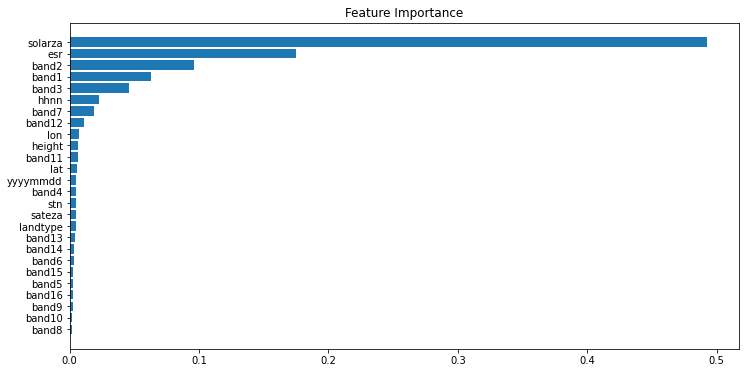

In [17]:
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

In [64]:
# X_test = test.drop('UV',axis=1)
# X_test['yyyymmdd'] = 0
# X_test['hhnn'] = 0
# for i in tqdm(range(len(X_test))):
#     X_test['yyyymmdd'][i] = int(str(X_test['YearMonthDayHourMinute'].values[i])[:8])
#     X_test['hhnn'][i] = int(str(X_test['YearMonthDayHourMinute'].values[i])[8:])

  0%|                                                                                        | 0/51855 [00:00<?, ?it/s]C:\Users\younjeongOh\AppData\Local\Temp\ipykernel_14800\679060299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['yyyymmdd'][i] = int(str(X_test['YearMonthDayHourMinute'].values[i])[:8])
C:\Users\younjeongOh\AppData\Local\Temp\ipykernel_14800\679060299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['hhnn'][i] = int(str(X_test['YearMonthDayHourMinute'].values[i])[8:])
100%|████████████████████████████████████████████████████████████████████████████| 51855/51855 [12:28<00:00, 69.3

In [65]:
# a =[]
# for i in range(len(X_test.columns)):
#     a.append(X_test.columns[i].lower())
# X_test.columns = a
# X_test

,yearmonthdayhourminute,stn,lon,lat,band1,band2,band3,band4,band5,band6,...,band14,band15,band16,solarza,sateza,esr,height,landtype,yyyymmdd,hhnn
0,202206010000,13,126.16000,33.30000,0.00000,0.00000,-0.00060,0.00060,-0.0003,-0.00065,...,250.11913,248.78686,243.12601,123.72706,38.96359,-5.16304,71.00,0,20220601,0
1,202206010000,105,128.89098,37.75147,-0.00057,-0.00057,0.00000,-0.00030,0.0000,0.00000,...,261.14580,257.52658,246.95577,119.74915,43.95463,-4.61100,26.04,3,20220601,0
2,202206010000,108,126.96500,37.57100,0.00000,-0.00057,-0.00030,0.00045,0.0000,0.00000,...,270.25616,266.99858,254.94651,119.65871,43.77999,-4.60329,85.50,3,20220601,0
3,202206010000,112,126.62490,37.47772,0.00000,0.00000,0.00060,0.00045,-0.0003,0.00000,...,272.33661,269.12853,256.15036,119.71313,43.67046,-4.61180,68.99,3,20220601,0
4,202206010000,115,130.89864,37.48129,0.00000,0.00000,0.00089,-0.00030,0.0003,0.00000,...,251.46606,249.01625,240.92761,120.21661,43.74521,-4.67107,222.80,4,20220601,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51850,202206250000,146,127.11900,35.84080,0.00000,-0.00057,-0.00089,0.00015,0.0000,0.00000,...,287.19605,285.48855,271.35400,119.84431,41.81018,-4.59718,62.90,3,20220625,0
51851,202206250000,152,129.33472,35.58250,-0.00057,0.00000,-0.00030,-0.00030,-0.0003,0.00000,...,293.51096,291.15861,274.60342,120.42121,41.52495,-4.67124,82.00,2,20220625,0
51852,202206250000,156,126.89158,35.17294,0.00000,0.00000,0.00089,-0.00030,-0.0003,-0.00065,...,290.23278,288.05655,273.15633,120.46896,41.04849,-4.68457,72.38,3,20220625,0
51853,202206250000,159,129.03203,35.10468,0.00000,0.00057,0.00030,-0.00075,-0.0003,0.00000,...,287.63090,285.01340,270.36623,120.85844,40.96396,-4.73249,69.56,3,20220625,0


In [67]:
# X_test.drop('yearmonthdayhourminute',axis=1,inplace=True)
# X_test

,stn,lon,lat,band1,band2,band3,band4,band5,band6,band7,...,band14,band15,band16,solarza,sateza,esr,height,landtype,yyyymmdd,hhnn
0,13,126.16000,33.30000,0.00000,0.00000,-0.00060,0.00060,-0.0003,-0.00065,262.92059,...,250.11913,248.78686,243.12601,123.72706,38.96359,-5.16304,71.00,0,20220601,0
1,105,128.89098,37.75147,-0.00057,-0.00057,0.00000,-0.00030,0.0000,0.00000,276.10419,...,261.14580,257.52658,246.95577,119.74915,43.95463,-4.61100,26.04,3,20220601,0
2,108,126.96500,37.57100,0.00000,-0.00057,-0.00030,0.00045,0.0000,0.00000,282.27548,...,270.25616,266.99858,254.94651,119.65871,43.77999,-4.60329,85.50,3,20220601,0
3,112,126.62490,37.47772,0.00000,0.00000,0.00060,0.00045,-0.0003,0.00000,282.46967,...,272.33661,269.12853,256.15036,119.71313,43.67046,-4.61180,68.99,3,20220601,0
4,115,130.89864,37.48129,0.00000,0.00000,0.00089,-0.00030,0.0003,0.00000,269.13950,...,251.46606,249.01625,240.92761,120.21661,43.74521,-4.67107,222.80,4,20220601,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51850,146,127.11900,35.84080,0.00000,-0.00057,-0.00089,0.00015,0.0000,0.00000,283.16913,...,287.19605,285.48855,271.35400,119.84431,41.81018,-4.59718,62.90,3,20220625,0
51851,152,129.33472,35.58250,-0.00057,0.00000,-0.00030,-0.00030,-0.0003,0.00000,293.89906,...,293.51096,291.15861,274.60342,120.42121,41.52495,-4.67124,82.00,2,20220625,0
51852,156,126.89158,35.17294,0.00000,0.00000,0.00089,-0.00030,-0.0003,-0.00065,287.05774,...,290.23278,288.05655,273.15633,120.46896,41.04849,-4.68457,72.38,3,20220625,0
51853,159,129.03203,35.10468,0.00000,0.00057,0.00030,-0.00075,-0.0003,0.00000,286.45840,...,287.63090,285.01340,270.36623,120.85844,40.96396,-4.73249,69.56,3,20220625,0


In [83]:
# X_test111 = pd.concat([X_test[X_test.columns[-2:]],X_test[X_test.columns[:-2]]], axis=1)
# X_test111

,yyyymmdd,hhnn,stn,lon,lat,band1,band2,band3,band4,band5,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20220601,0,13,126.16000,33.30000,0.00000,0.00000,-0.00060,0.00060,-0.0003,...,241.07130,251.49092,250.11913,248.78686,243.12601,123.72706,38.96359,-5.16304,71.00,0
1,20220601,0,105,128.89098,37.75147,-0.00057,-0.00057,0.00000,-0.00030,0.0000,...,244.35010,262.71227,261.14580,257.52658,246.95577,119.74915,43.95463,-4.61100,26.04,3
2,20220601,0,108,126.96500,37.57100,0.00000,-0.00057,-0.00030,0.00045,0.0000,...,249.24111,271.81756,270.25616,266.99858,254.94651,119.65871,43.77999,-4.60329,85.50,3
3,20220601,0,112,126.62490,37.47772,0.00000,0.00000,0.00060,0.00045,-0.0003,...,249.94977,273.52547,272.33661,269.12853,256.15036,119.71313,43.67046,-4.61180,68.99,3
4,20220601,0,115,130.89864,37.48129,0.00000,0.00000,0.00089,-0.00030,0.0003,...,239.88321,253.29031,251.46606,249.01625,240.92761,120.21661,43.74521,-4.67107,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51850,20220625,0,146,127.11900,35.84080,0.00000,-0.00057,-0.00089,0.00015,0.0000,...,258.49191,286.87485,287.19605,285.48855,271.35400,119.84431,41.81018,-4.59718,62.90,3
51851,20220625,0,152,129.33472,35.58250,-0.00057,0.00000,-0.00030,-0.00030,-0.0003,...,263.99872,293.32422,293.51096,291.15861,274.60342,120.42121,41.52495,-4.67124,82.00,2
51852,20220625,0,156,126.89158,35.17294,0.00000,0.00000,0.00089,-0.00030,-0.0003,...,261.53112,290.14436,290.23278,288.05655,273.15633,120.46896,41.04849,-4.68457,72.38,3
51853,20220625,0,159,129.03203,35.10468,0.00000,0.00057,0.00030,-0.00075,-0.0003,...,260.95627,287.80066,287.63090,285.01340,270.36623,120.85844,40.96396,-4.73249,69.56,3


In [97]:
X_test = test.drop('uv',axis=1)
X_test

,yyyymmdd,hhnn,stn,lon,lat,band1,band2,band3,band4,band5,...,band12,band13,band14,band15,band16,SolarZA,sateza,ESR,height,landtype
0,20220601,0,13,126.16000,33.30000,0.00000,0.00000,-0.00060,0.00060,-0.0003,...,241.07130,251.49092,250.11913,248.78686,243.12601,123.72706,38.96359,-5.16304,71.00,0
1,20220601,0,105,128.89098,37.75147,-0.00057,-0.00057,0.00000,-0.00030,0.0000,...,244.35010,262.71227,261.14580,257.52658,246.95577,119.74915,43.95463,-4.61100,26.04,3
2,20220601,0,108,126.96500,37.57100,0.00000,-0.00057,-0.00030,0.00045,0.0000,...,249.24111,271.81756,270.25616,266.99858,254.94651,119.65871,43.77999,-4.60329,85.50,3
3,20220601,0,112,126.62490,37.47772,0.00000,0.00000,0.00060,0.00045,-0.0003,...,249.94977,273.52547,272.33661,269.12853,256.15036,119.71313,43.67046,-4.61180,68.99,3
4,20220601,0,115,130.89864,37.48129,0.00000,0.00000,0.00089,-0.00030,0.0003,...,239.88321,253.29031,251.46606,249.01625,240.92761,120.21661,43.74521,-4.67107,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51850,20220625,0,146,127.11900,35.84080,0.00000,-0.00057,-0.00089,0.00015,0.0000,...,258.49191,286.87485,287.19605,285.48855,271.35400,119.84431,41.81018,-4.59718,62.90,3
51851,20220625,0,152,129.33472,35.58250,-0.00057,0.00000,-0.00030,-0.00030,-0.0003,...,263.99872,293.32422,293.51096,291.15861,274.60342,120.42121,41.52495,-4.67124,82.00,2
51852,20220625,0,156,126.89158,35.17294,0.00000,0.00000,0.00089,-0.00030,-0.0003,...,261.53112,290.14436,290.23278,288.05655,273.15633,120.46896,41.04849,-4.68457,72.38,3
51853,20220625,0,159,129.03203,35.10468,0.00000,0.00057,0.00030,-0.00075,-0.0003,...,260.95627,287.80066,287.63090,285.01340,270.36623,120.85844,40.96396,-4.73249,69.56,3


In [98]:
pred = xgb_model.predict(X_test)
pred

array([0.01582884, 0.01581963, 0.01582426, ..., 0.01586974, 0.01586605,
       0.01586879], dtype=float32)

In [107]:
pred = xgb_model.predict(X_test)
submission=pd.read_csv('1-1_검증데이터셋.csv', encoding='utf-8')
submission1=submission.copy()
submission1['UV'] = pred
submission1
submission1.to_csv("220224_xgb_uv_nooutlier_summer1.csv", index = False)

In [100]:
# X_test111.to_csv('202206_uv_final.csv', index=False)

In [101]:
# pd.read_csv('202206_uv_final.csv')

,yyyymmdd,hhnn,stn,lon,lat,band1,band2,band3,band4,band5,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
0,20220601,0,13,126.16000,33.30000,0.00000,0.00000,-0.00060,0.00060,-0.0003,...,241.07130,251.49092,250.11913,248.78686,243.12601,123.72706,38.96359,-5.16304,71.00,0
1,20220601,0,105,128.89098,37.75147,-0.00057,-0.00057,0.00000,-0.00030,0.0000,...,244.35010,262.71227,261.14580,257.52658,246.95577,119.74915,43.95463,-4.61100,26.04,3
2,20220601,0,108,126.96500,37.57100,0.00000,-0.00057,-0.00030,0.00045,0.0000,...,249.24111,271.81756,270.25616,266.99858,254.94651,119.65871,43.77999,-4.60329,85.50,3
3,20220601,0,112,126.62490,37.47772,0.00000,0.00000,0.00060,0.00045,-0.0003,...,249.94977,273.52547,272.33661,269.12853,256.15036,119.71313,43.67046,-4.61180,68.99,3
4,20220601,0,115,130.89864,37.48129,0.00000,0.00000,0.00089,-0.00030,0.0003,...,239.88321,253.29031,251.46606,249.01625,240.92761,120.21661,43.74521,-4.67107,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51850,20220625,0,146,127.11900,35.84080,0.00000,-0.00057,-0.00089,0.00015,0.0000,...,258.49191,286.87485,287.19605,285.48855,271.35400,119.84431,41.81018,-4.59718,62.90,3
51851,20220625,0,152,129.33472,35.58250,-0.00057,0.00000,-0.00030,-0.00030,-0.0003,...,263.99872,293.32422,293.51096,291.15861,274.60342,120.42121,41.52495,-4.67124,82.00,2
51852,20220625,0,156,126.89158,35.17294,0.00000,0.00000,0.00089,-0.00030,-0.0003,...,261.53112,290.14436,290.23278,288.05655,273.15633,120.46896,41.04849,-4.68457,72.38,3
51853,20220625,0,159,129.03203,35.10468,0.00000,0.00057,0.00030,-0.00075,-0.0003,...,260.95627,287.80066,287.63090,285.01340,270.36623,120.85844,40.96396,-4.73249,69.56,3


In [102]:
submission1

,YearMonthDayHourMinute,STN,UV
0,202206010000,13,0.015829
1,202206010000,105,0.015820
2,202206010000,108,0.015824
3,202206010000,112,0.015824
4,202206010000,115,0.015821
...,...,...,...
51850,202206250000,146,0.108240
51851,202206250000,152,0.015866
51852,202206250000,156,0.015870
51853,202206250000,159,0.015866


In [103]:
submission1['UV'].value_counts()      # 정렬해서 보기

0.015820    3919
0.015824    2680
0.015866    2652
0.015821    2633
0.015829    1370
            ... 
0.212267       1
0.187020       1
0.168107       1
0.122162       1
0.108240       1
Name: UV, Length: 32197, dtype: int64

<AxesSubplot:>

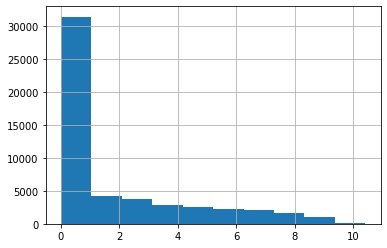

In [104]:
submission1['UV'].hist()      

In [105]:
submission1[submission1['UV']>7]

,YearMonthDayHourMinute,STN,UV
949,202206011030,115,7.147252
961,202206011040,105,7.240317
964,202206011040,115,7.258619
965,202206011040,131,7.053581
966,202206011040,132,7.250510
...,...,...,...
50975,202206241420,131,7.116374
50990,202206241430,131,7.308807
50999,202206241430,165,7.002812
51005,202206241440,131,7.059049


In [106]:
submission1[submission1['UV']<7]

,YearMonthDayHourMinute,STN,UV
0,202206010000,13,0.015829
1,202206010000,105,0.015820
2,202206010000,108,0.015824
3,202206010000,112,0.015824
4,202206010000,115,0.015821
...,...,...,...
51850,202206250000,146,0.108240
51851,202206250000,152,0.015866
51852,202206250000,156,0.015870
51853,202206250000,159,0.015866


In [ ]:
# 관측소별로 자외선 지수 분석할지.

<AxesSubplot:>

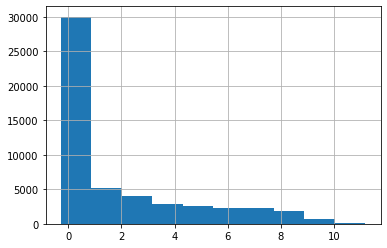

In [85]:
# pd.read_csv('220224.csv')['UV'].hist()

In [86]:
# pd.read_csv('220224.csv')

,YearMonthDayHourMinute,STN,UV
0,2.022060e+11,13,0.00471
1,2.022060e+11,105,0.00471
2,2.022060e+11,108,0.00471
3,2.022060e+11,112,0.00471
4,2.022060e+11,115,0.00471
...,...,...,...
51850,2.022060e+11,146,0.00471
51851,2.022060e+11,152,0.00471
51852,2.022060e+11,156,0.00471
51853,2.022060e+11,159,0.00471
